In [129]:
import importlib
import custom_transform  # import your module once

# After making changes to custom_transform.py
importlib.reload(custom_transform)


<module 'custom_transform' from '/Users/qasimayub/Documents/AI:ML/ATML/PA1/Task 1/custom_transform.py'>

In [130]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import os
from torchvision import transforms
from custom_transform import TranslateTransform, MaskPatchTransform, ShufflePatchTransform 
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
import random
import matplotlib.pyplot as plt
from timm import create_model
from collections import defaultdict

# Visualisation Functions

In [113]:
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(1, 1, -1)
    std = torch.tensor(std).view(1, 1, -1)
    return img * std + mean

def plot_images(dataloader, rows, cols, figsize, title):
    print(title)
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0)  # C,H,W → H,W,C
        img = denormalize(img, imagenet_mean, imagenet_std) # reverse normalization
        img = torch.clamp(img, 0, 1)      # clip to valid range
        
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(1, 1, -1)
    std = torch.tensor(std).view(1, 1, -1)
    return img * std + mean

def visualise_confidence(
    model, loader, device, class_names, num_images=5, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):  
    model.to(device)
    model.eval()

    # Get one batch (for random picking)
    x_all, y_all = next(iter(loader))
    x_all, y_all = x_all.to(device), y_all.to(device)

    fig, axs = plt.subplots(1, num_images, figsize=(3*num_images, 2))
    if num_images == 1:
        axs = [axs]

    for i in range(num_images):
        idx = random.randint(0, len(x_all) - 1)
        img = x_all[idx].unsqueeze(0)  # [1, C, H, W]
        label = y_all[idx].item()

        with torch.no_grad():
            outputs = model(img)
            logits = outputs.logits
            prob = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(prob, dim=1).item()
            confidence = prob[0, pred_label].item()

        # Denormalize and move to [H, W, C]
        img_vis = x_all[idx].detach().cpu().permute(1, 2, 0)
        img_vis = denormalize(img_vis, mean, std).clamp(0, 1)

        # Convert numeric labels to names if class_names provided
        true_name = class_names[label]
        pred_name = class_names[pred_label]

        # Plot
        axs[i].imshow(img_vis)
        axs[i].axis("off")
        axs[i].set_title(f"TL={true_name}, PL={pred_name}\nC={confidence:.2f}")

    plt.tight_layout()
    plt.show()


# Loading the model

In [114]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
for param in model.parameters():
  param.requires_grad = False
model.classifier = torch.nn.Linear(model.classifier.in_features, 10)

# Base Datasets

In [115]:
# mean and sd for normalisation
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Transform
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [117]:
# Training set
train_dataset = torchvision.datasets.STL10(root="./data/stl", split="train", download=False, transform=base_transform)

# # Normal Test set
norm_test_dataset = torchvision.datasets.STL10(
    root="./data/stl", split='test', download=False, transform=base_transform
)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
norm_test_loader = torch.utils.data.DataLoader(norm_test_dataset, batch_size=64, shuffle=False, num_workers=2)

# get names of classes
class_names = train_dataset.classes

# Train Loop

In [118]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.to(device)
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)              # forward pass
        logits = outputs.logits              # ViT returns ModelOutput
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.to(device)
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            logits = outputs.logits            # take logits
            loss = criterion(logits, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def per_class_accuracy(model, loader, device, class_names=None):
    model.eval()
    model.to(device)

    correct_per_class = defaultdict(int)
    total_per_class = defaultdict(int)

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            for label, pred in zip(labels, preds):
                total_per_class[label.item()] += 1
                if pred.item() == label.item():
                    correct_per_class[label.item()] += 1

    # Compute accuracy per class
    accuracies = {}
    for label in range(len(total_per_class)):
        total = total_per_class[label]
        correct = correct_per_class[label]
        acc = 100.0 * correct / total if total > 0 else 0.0
        name = class_names[label] if class_names is not None else str(label)
        accuracies[name] = acc

    return accuracies


In [119]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
lossfn = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Model - TRAINING")
for i in range(2):
  train_loss, train_acc = train_epoch(model, train_loader, lossfn, optimizer, device)
  print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
  test_loss, test_acc = evaluate(model, norm_test_loader, lossfn, device)
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")
  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  test_losses.append(test_loss)
  test_accuracies.append(test_acc)

Model - TRAINING
Train Loss: 0.3310899689912796, Train Accuracy: 93.26
Test Loss: 0.07211553305387497, Test Accuracy: 98.3375
Train Loss: 0.049354525104165076, Train Accuracy: 98.92
Test Loss: 0.057119675844907764, Test Accuracy: 98.4625


## GrayScale

In [120]:
gray_scale_transform = torchvision.transforms.Compose([
  torchvision.transforms.Resize((224, 224)),
  torchvision.transforms.Grayscale(num_output_channels=3),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(imagenet_mean, imagenet_std)
])

# gray scale dataset
grs_test_dataset = torchvision.datasets.STL10(root="./data/stl", split='test', download=False, transform=gray_scale_transform)
grs_test_loader = torch.utils.data.DataLoader(grs_test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [121]:
print("ViT - Grayscale")
grs_loss, grs_acc = evaluate(model, grs_test_loader, lossfn, device)
print(f"Grayscale Loss: {grs_loss}, Grayscale Accuracy: {grs_acc}")


ViT - Grayscale
Grayscale Loss: 0.14245470820367337, Grayscale Accuracy: 95.575


## Cue Conflicted

In [122]:
print("ViT - Cue Conflict")
cue_test_dataset = torchvision.datasets.ImageFolder(root="./data/cue_conflict_dataset", transform=base_transform)
cue_test_loader = torch.utils.data.DataLoader(cue_test_dataset, batch_size=64, shuffle=False, num_workers=2)
cue_loss, cue_acc = evaluate(model, cue_test_loader, lossfn, device)
print(f"Cue Loss: {cue_loss}, Cue Accuracy: {cue_acc}")
print(f"Shape Bias %: {((cue_acc/test_acc)*100)}")


ViT - Cue Conflict
Cue Loss: 2.2278094844818117, Cue Accuracy: 27.15
Shape Bias %: 27.57394947314967


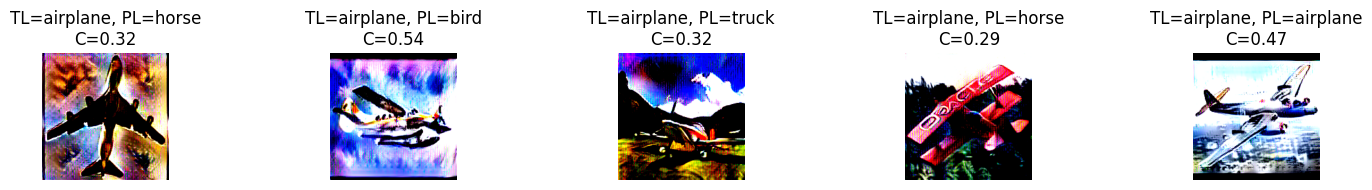

In [123]:
visualise_confidence(model, cue_test_loader, device, class_names)

# Accuracy by label

In [124]:
per_class_accuracy(model, cue_test_loader, device, class_names)

{'airplane': 7.625,
 'bird': 42.25,
 'car': 88.75,
 'cat': 7.375,
 'deer': 1.375,
 'dog': 22.625,
 'horse': 42.0,
 'monkey': 14.0,
 'ship': 2.375,
 'truck': 43.125}

In [ ]:
# # Data distribution
# from torch.utils.data import Subset
# for target_class in range(10):
#     indices = [i for i, y in enumerate(cue_test_dataset.targets) if y == target_class]

#     subset = Subset(cue_test_dataset, indices)
#     print(f"{class_names[target_class]} = {len(subset)}") 

airplane = 800
bird = 800
car = 800
cat = 800
deer = 800
dog = 800
horse = 800
monkey = 800
ship = 800
truck = 800


## Translate


In [131]:
translate_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),   # resize to 224x224 for ViT-S/16
    torchvision.transforms.ToTensor(),           # convert to tensor
    TranslateTransform(40),
    torchvision.transforms.Normalize(imagenet_mean, imagenet_std)  # normalize [-1, 1]
])

tr_test_dataset = torchvision.datasets.STL10(root="./data/stl", split="test", download=False, transform=translate_transform)
tr_test_loader = torch.utils.data.DataLoader(tr_test_dataset, batch_size=64, shuffle=False)

In [132]:
tr_loss, tr_acc = evaluate(model, tr_test_loader, lossfn, device)
print(f"Translation Loss: {tr_loss}, Translation Accuracy: {tr_acc}")

Translation Loss: 0.07802123489975929, Translation Accuracy: 97.8


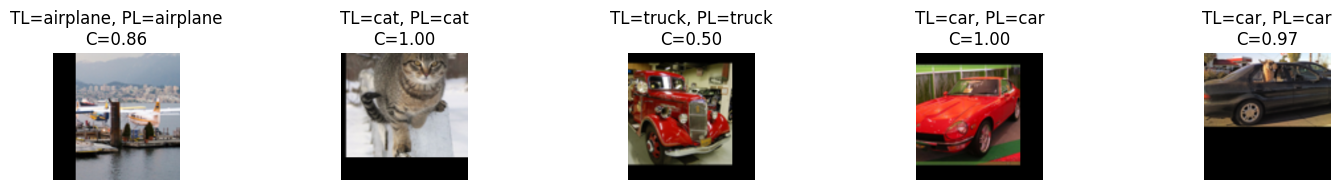

In [136]:
visualise_confidence(model, tr_test_loader, device, class_names)

# Masked

In [137]:
mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),   # resize to 224x224 for ViT-S/16
    torchvision.transforms.ToTensor(),           # convert to tensor
    MaskPatchTransform(25),
    torchvision.transforms.Normalize(imagenet_mean, imagenet_std)  # normalize [-1, 1]
])

ms_test_dataset = torchvision.datasets.STL10(root="./data/stl", split="test", download=False, transform=mask_transform)
ms_test_loader = torch.utils.data.DataLoader(ms_test_dataset, batch_size=64, shuffle=False)

In [138]:
ms_loss, ms_acc = evaluate(model, ms_test_loader, lossfn, device)
print(f"Masked Loss: {ms_loss}, Masked Accuracy: {ms_acc}")

Masked Loss: 0.30241343545913696, Masked Accuracy: 90.975


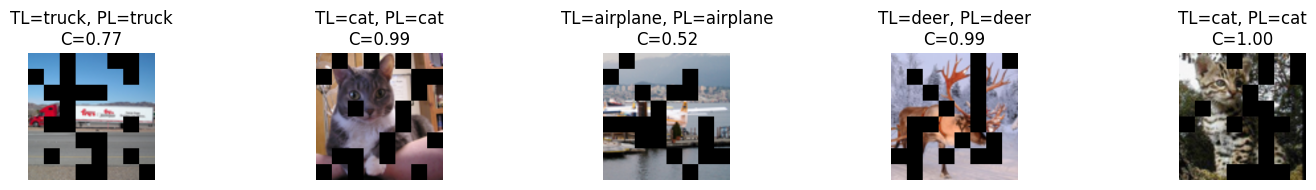

In [139]:
visualise_confidence(model, ms_test_loader, device, class_names)

# Permutation Invariance

In [140]:
perm_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),   # resize to 224x224 for ViT-S/16
    torchvision.transforms.ToTensor(),           # convert to tensor
    ShufflePatchTransform(),
    torchvision.transforms.Normalize(imagenet_mean, imagenet_std)  # normalize [-1, 1]
])

perm_test_dataset = torchvision.datasets.STL10(root="./data/stl", split="test", download=False, transform=perm_transform)
perm_test_loader = torch.utils.data.DataLoader(perm_test_dataset, batch_size=64, shuffle=False)

In [141]:
perm_loss, perm_acc = evaluate(model, perm_test_loader, lossfn, device)
print(f"Permutation Loss: {perm_loss}, Permutation Accuracy: {perm_acc}")

Permutation Loss: 2.5575899066925047, Permutation Accuracy: 15.0375


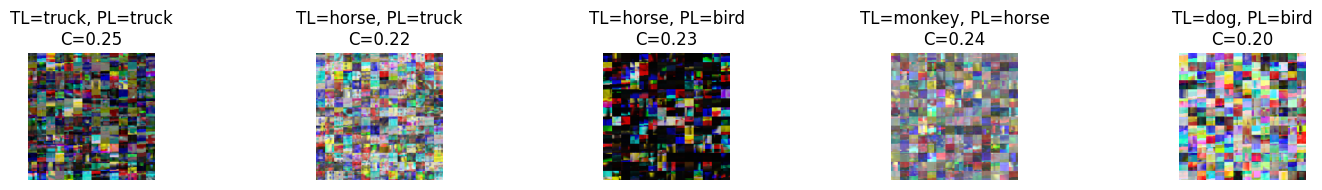

In [142]:
visualise_confidence(model, perm_test_loader, device, class_names)